# Curved lane detection using classical image processing

In [1]:
#imports
import matplotlib.pyplot as plt
import numpy as np
import pickle 
import cv2 
import glob
from PIL import Image
%matplotlib inline

## Transforming images into thresholded binary images using color transforms and gradients

In [2]:
# magnitude thresholding 
def thresh_mag(img, kernel=3, thresh=[0,255]):
    x= cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=kernel)
    y= cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=kernel)
    #gradient magnitude
    mag_grad= np.sqrt(x**2 + y**2)
    #rescaling to 8 bits
    scale = np.max(mag_grad)/255 
    mag_grad = (mag_grad/scale).astype(np.uint8)
    output = np.zeros_like(mag_grad)
    output[(mag_grad >= thresh[0]) & (mag_grad <= thresh[1])] = 1
    
    return output

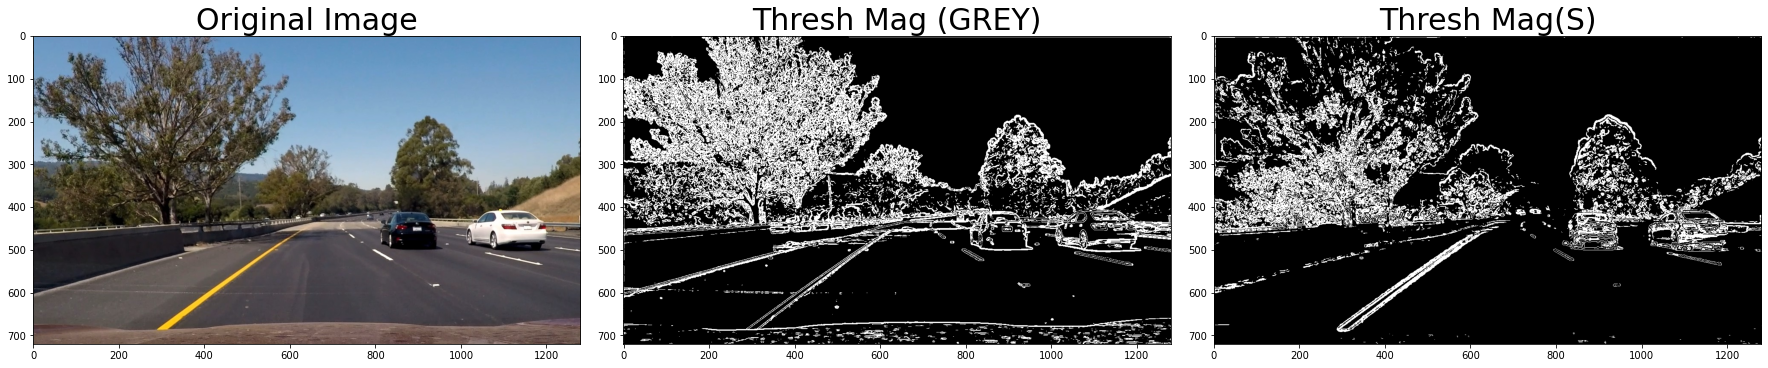

In [3]:
img = cv2.imread('test_images/test6.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

gray_scaled = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
s_channel = hls[:,:,2]
    

grey_threshold = thresh_mag(gray_scaled, kernel=5, thresh=[20, 100])
s_channel_threshold = thresh_mag(s_channel, kernel=5, thresh=[20, 100])
# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(grey_threshold, cmap='gray')
ax2.set_title('Thresh Mag (GREY)', fontsize=30)
ax3.imshow(s_channel_threshold, cmap='gray')
ax3.set_title('Thresh Mag(S)', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Combuting direction of the gradient

In [4]:
def grad_dir(img, kernel=3, thresh=[0, np.pi/2]):
    x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=kernel)
    y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absolute_grad = np.arctan2(np.absolute(y), np.absolute(x))
    output =  np.zeros_like(absolute_grad)
    output[(absolute_grad >= thresh[0]) & (absolute_grad <= thresh[1])] = 1

    return output

In [5]:
cameraCalibration = pickle.load( open('./pickled_data/camera_calibration.p', 'rb' ) )
mtx, dist = map(cameraCalibration.get, ('mtx', 'dist'))

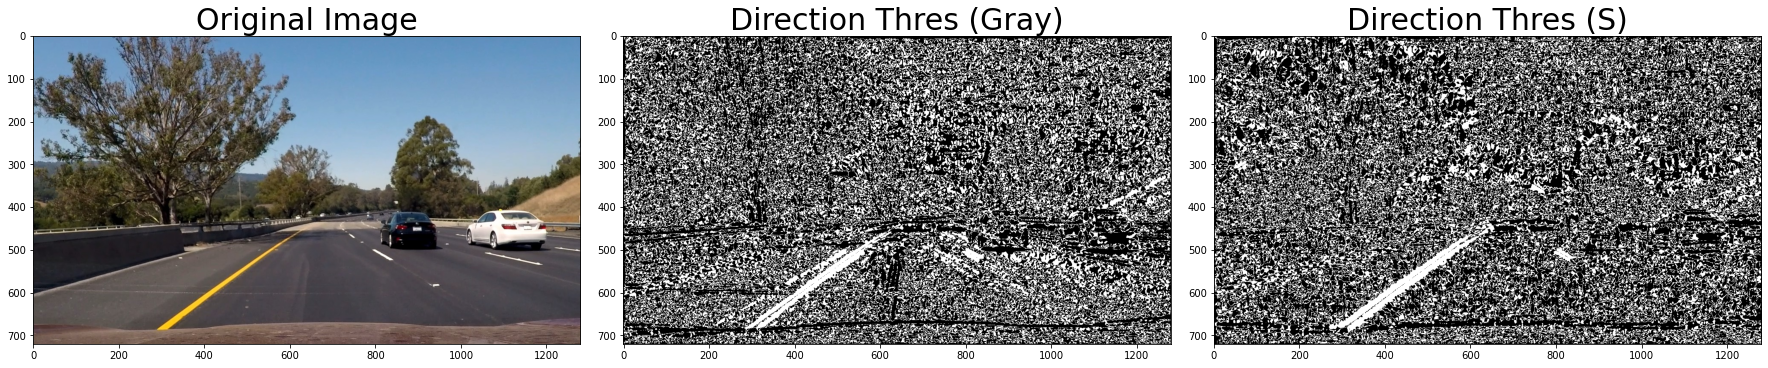

In [6]:
img = cv2.imread('test_images/test6.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

gray_scaled = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
s_channel = hls[:,:,2]

dir_gray =grad_dir(gray_scaled, kernel=15, thresh=[0.7, 1.3])
dir_s = grad_dir(s_channel, kernel=15, thresh=[0.7, 1.3])

# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dir_gray, cmap='gray')
ax2.set_title('Direction Thres (Gray)', fontsize=30)
ax3.imshow(dir_s, cmap='gray')
ax3.set_title('Direction Thres (S)', fontsize = 30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Calculating absolute threshold

In [7]:
def abs_thresh(img,thresh=[0,255]):
    gray_scaled = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    abs_x =np.absolute(cv2.Sobel(gray_scaled, cv2.CV_64F, 1, 0))
    abs_y =np.absolute(cv2.Sobel(gray_scaled, cv2.CV_64F, 0, 1))
    scaled_x= np.uint8(255*abs_x/np.max(abs_x))
    scaled_y= np.uint8(255*abs_y/np.max(abs_y))
    
    output_x =np.zeros_like(scaled_x)
    output_y =np.zeros_like(scaled_y)
    output_x[(scaled_x >= thresh[0]) & (scaled_x <= thresh[1])] = 1
    output_y[(scaled_y >= thresh[0]) & (scaled_y <= thresh[1])] = 1
    
    return output_x, output_y

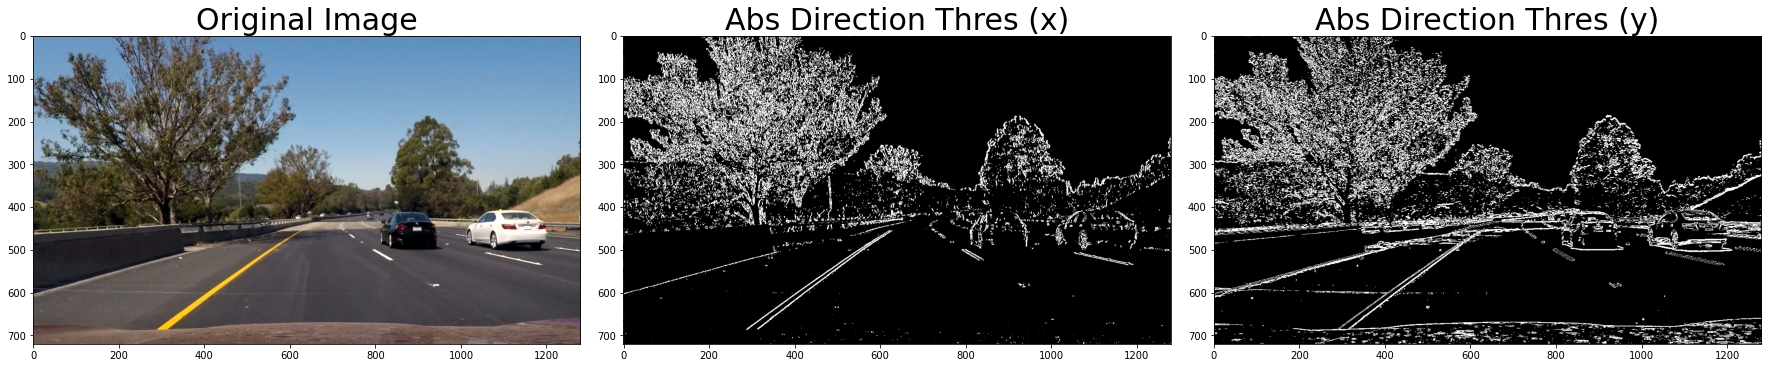

In [8]:
img = cv2.imread('test_images/test6.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


abs_x,abs_y = abs_thresh(img=img,thresh=[20,100])
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(abs_x, cmap='gray')
ax2.set_title('Abs Direction Thres (x)', fontsize=30)
ax3.imshow(abs_y, cmap='gray')
ax3.set_title('Abs Direction Thres (y)', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Combining thresholds 

In [9]:
def combined(img):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    abs_x,abs_y = abs_thresh(img=img,thresh=[20,100])
    dir_s =grad_dir(s_channel,15,[0.7,1.3])
    mag_s= thresh_mag(img=s_channel,kernel=3,thresh=[20,100])
    
    combined = np.zeros_like(dir_s)
    combined[((abs_x == 1) & (abs_y == 1)) | ((mag_s == 1) & (dir_s == 1))] = 1
    return combined

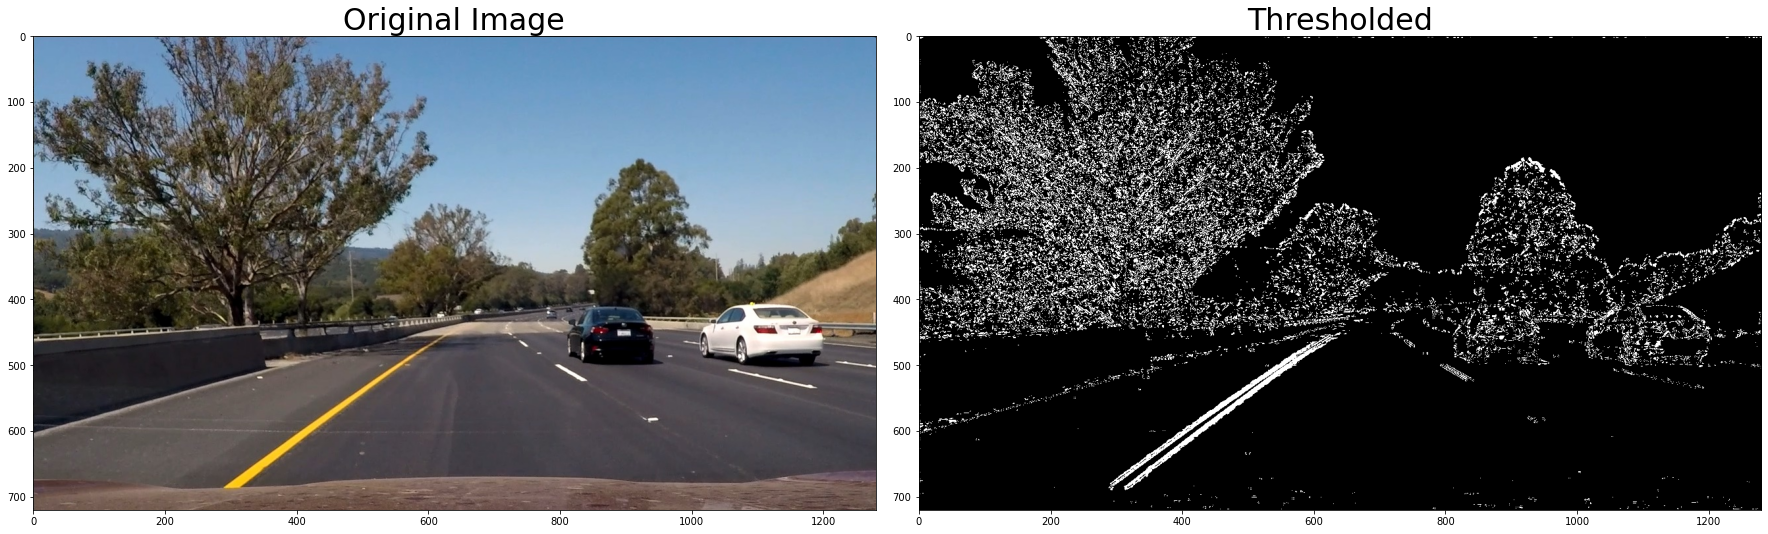

In [10]:
img = cv2.imread('test_images/test6.jpg')
combined_thresh = combined(img)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(combined_thresh, cmap='gray')
ax2.set_title('Thresholded', fontsize=30)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Perspective transformation (birds-eye view)

In [11]:
img = cv2.imread('test_images/test1.jpg')

undist = cv2.undistort(img, mtx, dist, None, mtx)

xSize, ySize, _ = undist.shape
copy = undist.copy()

bottomY = 720
topY = 455


left1 = (190, bottomY)
left1_x, left1_y = left1
left2 = (550, topY)
left2_x, left2_y = left2

right1 = (705, topY)
right1_x, right1_y = right1

right2 = (970, bottomY)
right2_x, right2_y = right2
gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
src = np.float32([ 
    [left2_x, left2_y],
    [right1_x, right1_y],
    [right2_x, right2_y],
    [left1_x, left1_y]
])
nX = gray.shape[1]
nY = gray.shape[0]
img_size = (nX, nY)
offset = 200
dst = np.float32([
    [offset, 0],
    [img_size[0]-offset, 0],
    [img_size[0]-offset, img_size[1]], 
    [offset, img_size[1]]
])
img_size = (gray.shape[1], gray.shape[0])
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
height, width = img.shape[0:2]
top_space = 80
bottom_space=400
source = np.float32(
    [
        [(width/2) - top_space, height*0.65],        
        [(width/2) + top_space+40, height*0.65],        
        [(width/2) + bottom_space + 100, height-50],
        [(width/2) - bottom_space, height-50]
    ])

destination = np.float32(
    [
        [(width/2) - bottom_space, height*0.15],        
        [(width/2) + bottom_space, height*0.15],        
        [(width/2) + bottom_space, height],
        [(width/2) - bottom_space, height]
    ])


Text(0.5, 1.0, "Bird's Eye view")

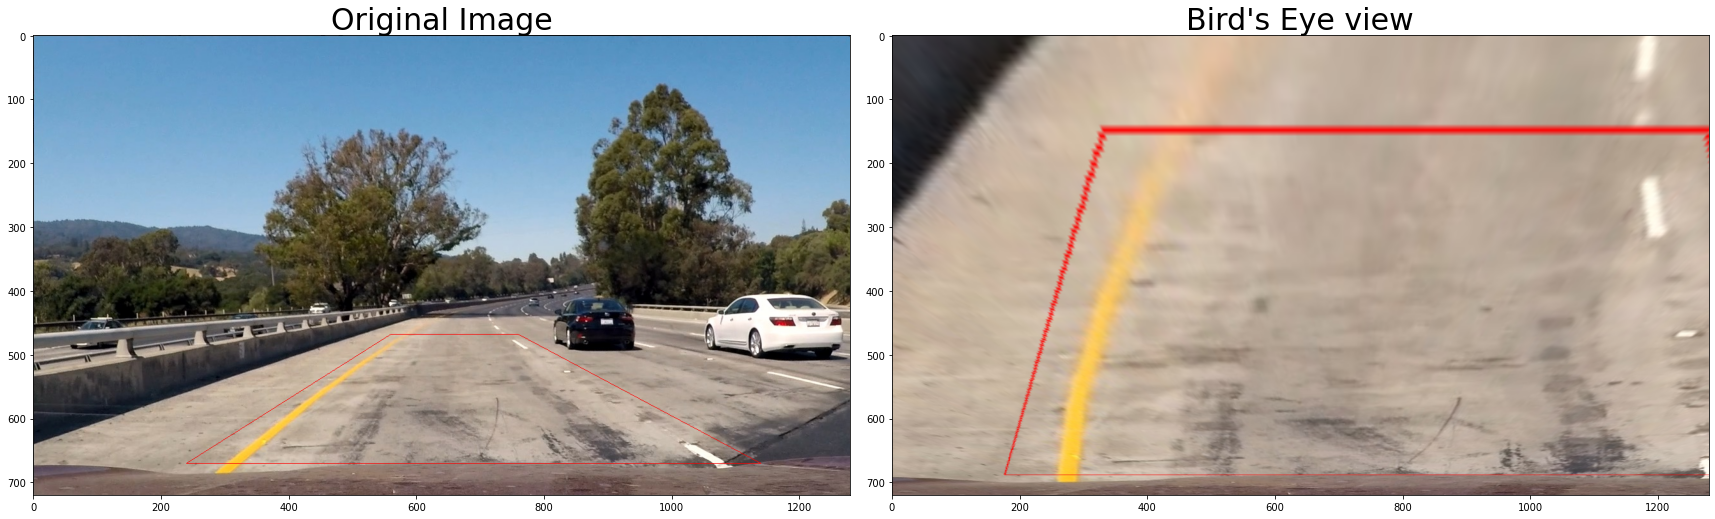

In [12]:
#M = cv2.getPerspectiveTransform(source, destination)
#Minv = cv2.getPerspectiveTransform(destination, source)

src=source.astype('int32')
dst=destination.astype('int32')
#warped_image = cv2.warpPerspective(img, M, (width, height), flags=cv2.INTER_LINEAR)

def draw_quad(img,src,color=[0,0,255],width=1):
    p1, p2, p3, p4 = src
    cv2.line(img, tuple(p1), tuple(p2), color, width)
    cv2.line(img, tuple(p2), tuple(p3), color, width)
    cv2.line(img, tuple(p3), tuple(p4), color, width)
    cv2.line(img, tuple(p4), tuple(p1), color, width)
    
draw_quad(img,src)
warped_image = cv2.warpPerspective(img, M, (width, height), flags=cv2.INTER_LINEAR)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(cv2.cvtColor(warped_image,cv2.COLOR_BGR2RGB))
ax2.set_title("Bird's Eye view", fontsize=30)

In [13]:
img = cv2.imread('test_images/test1.jpg')

combined_thresh= combined(img)
warped_image = cv2.warpPerspective(combined_thresh, M, (width, height), flags=cv2.INTER_LINEAR)

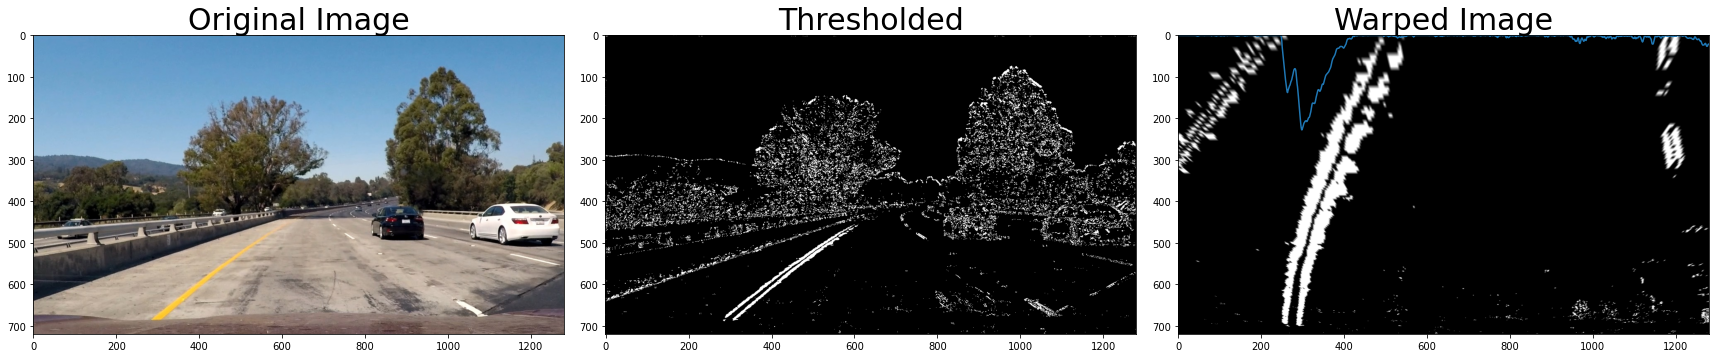

In [14]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(combined_thresh, cmap='gray')
ax2.set_title('Thresholded', fontsize=30)
ax3.imshow(warped_image, cmap='gray')
ax3.set_title('Warped Image', fontsize=30)
histogram = np.sum(warped_image[warped_image.shape[0]//2:,:], axis=0)
plt.plot(histogram)

In [15]:
def get_lane_poly(img):
    #histogram of the bottom half of the image
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    #image to visualize the result
    out_img = np.dstack((img, img, img))*255
    #find the maximum right and left values in the histogram
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    
    nwindows = 100
    window_height = np.int(img.shape[0]/nwindows)
    #find all nonzero pixels for x and y coordinates
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # parameters for the sliding window
    margin = 100
    minimum_pixels = 50

    # left and right lane indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minimum_pixels pixels, recenter next window on their mean position
        if len(good_left_inds) > minimum_pixels:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minimum_pixels:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
        
    return ploty, left_fitx, right_fitx, left_fit, right_fit,out_img

In [16]:
cameraCalibration = pickle.load( open('./pickled_data/camera_calibration.p', 'rb' ) )
mtx, dist = map(cameraCalibration.get, ('mtx', 'dist'))

In [17]:
def undistort(img):
    img_size = (img.shape[1], img.shape[0])
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

In [18]:
img = cv2.imread('test_images/test2.jpg')

def plot_lane_poly(input_img):
    img=undistort(input_img)
    #Threasholded image
    combined_thresh = combined(img)

    warped_image = cv2.warpPerspective(combined_thresh, M, (width, height), flags=cv2.INTER_LINEAR)

    ploty, left_fitx, right_fitx, left_fit, right_fit,out_img = get_lane_poly(warped_image)
    
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(out_img)
    ax2.set_title("Output Image", fontsize=30)
    ax2.plot(left_fitx, ploty, color='blue')
    ax2.plot(right_fitx, ploty, color='blue')

<ipython-input-15-56ea3c865cc9>:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histogram.shape[0]/2)
<ipython-input-15-56ea3c865cc9>:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20;

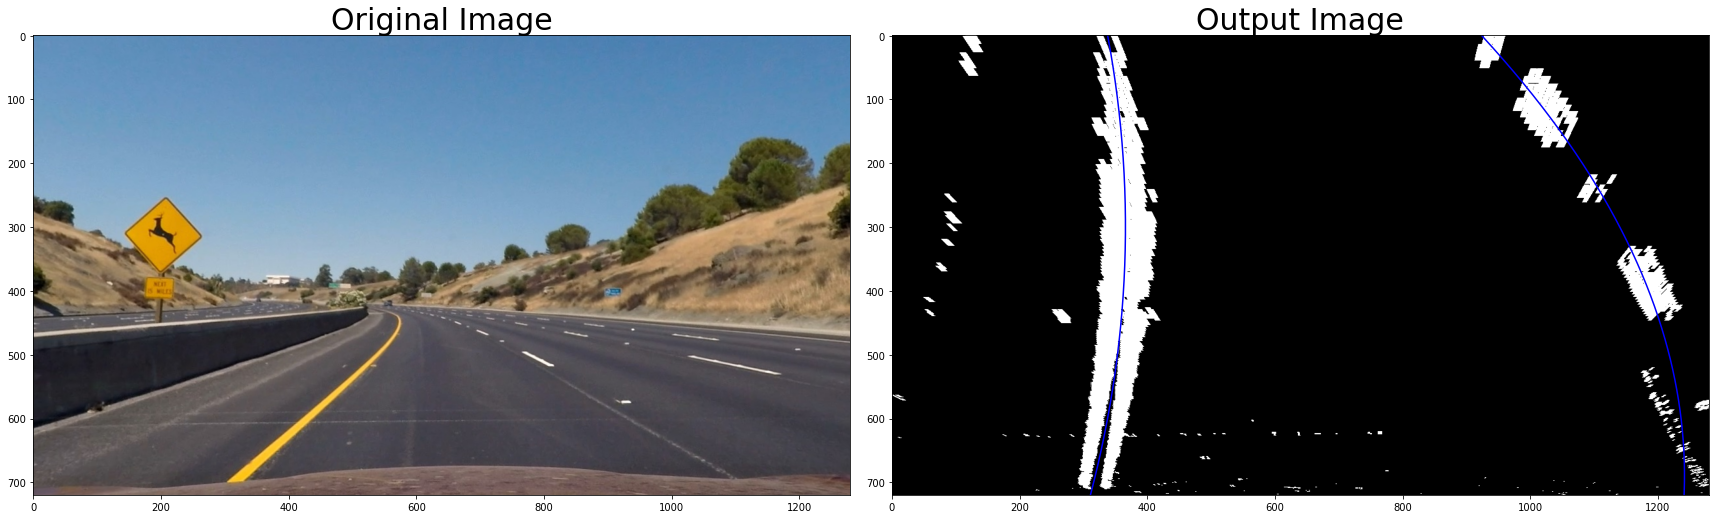

In [19]:
plot_lane_poly(img)

In [20]:
def poly_fast(img, left_fit,  right_fit):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "img")
    # It's now much easier to find line pixels!
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return ploty, left_fitx, right_fitx, left_fit, right_fit

In [21]:
def curvature_estimation(ploty, leftx, rightx):
    y = np.max(ploty)

    # Define conversions in x and y from pixels space to meters
    pix2meters_y = 30 / 720 # meters per pixel in y dimension
    pix2meters_x = 3.7 / 700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*pix2meters_y, leftx*pix2meters_x, 2)
    right_fit_cr = np.polyfit(ploty*pix2meters_y, rightx*pix2meters_x, 2)

    # Calculate the new radii of curvature
    l_curvature = ((1 + (2*left_fit_cr[0]*y*pix2meters_y + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    r_curvature = ((1 + (2*right_fit_cr[0]*y*pix2meters_y + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    # Now our radius of curvature is in meters
    # print(l_curvature, 'm', r_curvature, 'm')

    return (l_curvature+r_curvature)/2

In [22]:
src = np.float32([ 
    [left2_x, left2_y],
    [right1_x, right1_y],
    [right2_x, right2_y],
    [left1_x, left1_y]
])
nX = gray.shape[1]
nY = gray.shape[0]
img_size = (nX, nY)
offset = 200
dst = np.float32([
    [offset, 0],
    [img_size[0]-offset, 0],
    [img_size[0]-offset, img_size[1]], 
    [offset, img_size[1]]
])

In [23]:
def add_lane(img, ploty, leftx, rightx):

    Minv = cv2.getPerspectiveTransform(dst, src)

    # Create an img to draw the lines on
    warp_zero = np.zeros_like(img[:,:,0]).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    left_points = np.array([np.transpose(np.vstack([leftx, ploty]))])
    right_points = np.array([np.flipud(np.transpose(np.vstack([rightx, ploty])))])
    pts = np.hstack((left_points, right_points))

    # Draw the lane onto the warped blank img
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Warp the blank back to original img space using inverse perspective matrix (Minv)
    new_warp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 

    # Combine the result with the original img
    result = cv2.addWeighted(img, 1, new_warp, 0.3, 0)
    
    return result

In [24]:
def draw_lane(img,name):
#Threasholded image
    combined_thresh = combined(img)

    warped_image = cv2.warpPerspective(combined_thresh, M, (width, height), flags=cv2.INTER_LINEAR)

    ploty, left_fitx, right_fitx, left_fit, right_fit,out_img = get_lane_poly(warped_image)
    
    result=add_lane(img,ploty,left_fitx,right_fitx)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax1.set_title(f'{name}', fontsize=30)
    ax2.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    ax2.set_title("Output Image", fontsize=30)

<ipython-input-15-56ea3c865cc9>:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histogram.shape[0]/2)
<ipython-input-15-56ea3c865cc9>:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20;

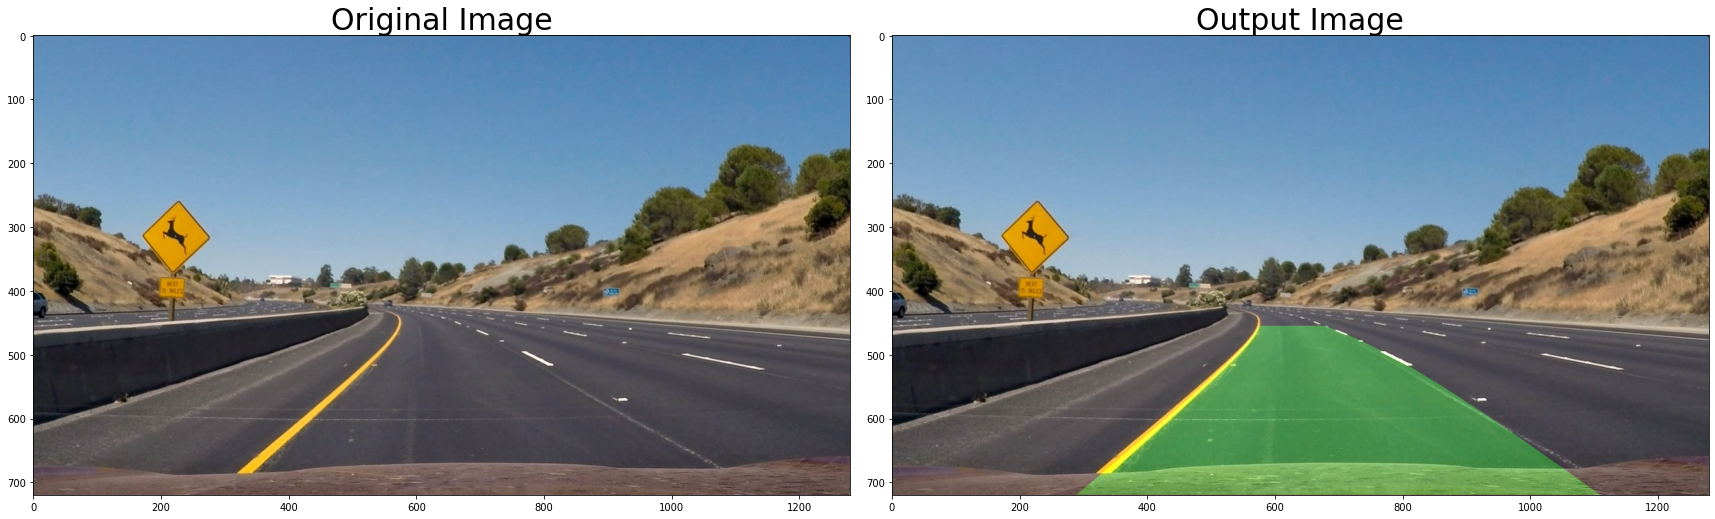

In [25]:
img = cv2.imread('test_images/test2.jpg')
draw_lane(img,'Original Image')

In [26]:
left_fit_img = None
right_fit_img = None

def process_image(input_image):
    global left_fit_img
    global right_fit_img
    image = undistort(input_image)
    # step 1: detect binary lane markings
    thresholded_image = combined(image)
    
    
    # step 2: perspective transform
    warped_img = cv2.warpPerspective(thresholded_image, M, (width, height), flags=cv2.INTER_LINEAR)
    
    
    # step 3: fit polynomials
    if left_fit_img is not None:
        ploty, left_fitx, right_fitx, left_fit, right_fit,out_img = get_lane_poly(warped_img)
    else:
        ploty, left_fitx, right_fitx, left_fit, right_fit,out_img = get_lane_poly(warped_img)
    
    left_fit_img = left_fit
    right_fit_img = right_fit
    
    # step 5: draw lane
    output_lane = add_lane(image, ploty, left_fitx, right_fitx)
    
    # step 6: print curvature
    curv = curvature_estimation(ploty, left_fitx, right_fitx)
    output_curvature = cv2.putText(output_lane, "Radius of Curvature=" + str(int(curv)) + "(m)", (50, 80), cv2.FONT_HERSHEY_SIMPLEX, 1, [0, 0, 0], 2)

    # step 7: print road position
    xm_per_pix = 3.7/700
    left_lane_pos = left_fitx[len(left_fitx)-1]
    right_lane_pos = right_fitx[len(right_fitx)-1]
    road_pos = (((left_lane_pos + right_lane_pos) / 2) - 640) * xm_per_pix
    if road_pos>0:
        output_road_pos = cv2.putText(output_curvature, "Vehicle is {0:.3f}m left of center".format(road_pos), (50, 120), cv2.FONT_HERSHEY_SIMPLEX, 1, [0, 0, 0], 2)
    elif road_pos<0:
        output_road_pos = cv2.putText(output_curvature, "Vehicle is {0:.3f}m right of center".format(abs(road_pos)), (50, 120), cv2.FONT_HERSHEY_SIMPLEX, 1, [0, 0, 0], 2)
    else:
        output_road_pos = cv2.putText(output_curvature, "Vehicle is on the center".format(abs(road_pos)), (50, 120), cv2.FONT_HERSHEY_SIMPLEX, 1, [0, 0, 0], 2)
    thresholded_image=cv2.resize(thresholded_image,(300,150), interpolation = cv2.INTER_AREA)
    warped_img = cv2.resize(warped_img,(300,150), interpolation = cv2.INTER_AREA)
    # output from processing step
    output_image = output_road_pos
    warped_img= cv2.merge([warped_img,warped_img,warped_img])*255
    warped_img = warped_img.astype(np.uint8)
    thresholded_image= cv2.merge([thresholded_image,thresholded_image,thresholded_image])*255
    thresholded_image = thresholded_image.astype(np.uint8)
    output_image=Image.fromarray(output_image)
    warped_img= Image.fromarray(warped_img)
    thresholded_image= Image.fromarray(thresholded_image)
    #thresholded_image_3=cv2.merge([thresholded_image,thresholded_image,thresholded_image])*255
    output_image.paste(warped_img,(900,100))
    output_image.paste(thresholded_image,(900,300))
    output_image = np.array(output_image) 

    # function should always output color images
    if len(output_image.shape) == 2:
        return cv2.cvtColor(np.float32(output_image), cv2.COLOR_GRAY2RGB)
    else:
        return output_image


<ipython-input-15-56ea3c865cc9>:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histogram.shape[0]/2)
<ipython-input-15-56ea3c865cc9>:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20;

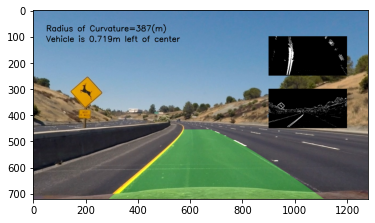

In [27]:
img = cv2.imread('test_images/test2.jpg')
output=process_image(img)
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))

In [28]:
from moviepy.editor import VideoFileClip

project_output_file = "challenge_output.mp4"
project_video = VideoFileClip("challenge_video.mp4")

project_output = project_video.fl_image(process_image)
%time project_output.write_videofile(project_output_file, audio=False)

Moviepy - Building video challenge_output.mp4.
Moviepy - Writing video challenge_output.mp4



Moviepy - Done !
Moviepy - video ready challenge_output.mp4
Wall time: 3min 26s
